<a href="https://colab.research.google.com/github/hasnain003/Flower-Classifier/blob/master/Image_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import time
from torch.optim import lr_scheduler
from collections import OrderedDict
import copy

In [0]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:

!wget -c https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip;
!unzip -qq flower_data.zip;

--2019-03-25 04:41:14--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.1.155
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.1.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip     100%[===================>] 297.01M  97.4MB/s    in 3.0s    

2019-03-25 04:41:17 (97.4 MB/s) - ‘flower_data.zip’ saved [311442766/311442766]



In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
# TODO: Define your transforms for the training and validation sets
data_transforms = {'train': transforms.Compose([transforms.RandomRotation(30),
                                                transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize(
                                                        [0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])]),
                   'valid':transforms.Compose([transforms.Resize(224),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(
                                                        [0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])
                  }

# TODO: Load the datasets with ImageFolder
image_datasets = {'train': datasets.ImageFolder(train_dir, transform= data_transforms['train']),
                  'valid': datasets.ImageFolder(valid_dir, transform= data_transforms['valid'])}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size= 64, shuffle= True),
               'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=64)}

In [0]:
dataset_sizes = {'train': len(image_datasets['train']),
                 'valid': len(image_datasets['valid'])}
class_names = image_datasets['train'].classes

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json

In [0]:
!ls

cat_to_name.json  flower_data  flower_data.zip	sample_data


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import json
drive_path = '/content/gdrive/My Drive/Colab/course-content/'
file_path = F"{drive_path}cat_to_name.json"
with open(file_path, 'r') as f:
  cat_to_name = json.load(f)

In [0]:
number_categories = len(cat_to_name)  
print('Number of categories: ', number_categories)

Number of categories:  102


In [0]:
# changing categories to their actual names 
for i in range(0,len(class_names)):
    class_names[i] = cat_to_name.get(class_names[i])

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
# Build and train your network
model = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
241530880it [00:02, 85609101.77it/s]


In [0]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
for param in model.parameters():
    param.requires_grad = False
 
from collections import OrderedDict
classifier = nn.Sequential( OrderedDict(
[
    ('fc1', nn.Linear(2048, 4096)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(0.3)),
    ('fc4', nn.Linear(4096, number_categories)),
    ('output', nn.LogSoftmax(dim=1))
]))

In [0]:
model.fc = classifier


In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

In [0]:
def train_model(model, criteria, optimizer, num_epochs=25, device='cuda'):
    """
    Train the model
    :param model:
    :param criteria:
    :param optimizer:
    :param scheduler:
    :param num_epochs:
    :param device:
    :return:
    """
    model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'model_challenge.pt')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
  
    return model


In [0]:
# Decay LR by a factor of 0.1 every 4 epochs
#sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
# Number of epochs
eps = 15

device = "cuda" if torch.cuda.is_available() else "cpu"
#model_ft = train_model(model, criterion, optimizer, sched, eps, device)
model_ft = train_model(model, criterion, optimizer, eps, device)

Epoch 0/14
----------
train Loss: 4.2863 Acc: 0.1885
valid Loss: 1.7366 Acc: 0.5623

Epoch 1/14
----------
train Loss: 1.9621 Acc: 0.4718
valid Loss: 1.0547 Acc: 0.7054

Epoch 2/14
----------
train Loss: 1.6282 Acc: 0.5504
valid Loss: 0.8045 Acc: 0.7958

Epoch 3/14
----------
train Loss: 1.4553 Acc: 0.5939
valid Loss: 0.7961 Acc: 0.7885

Epoch 4/14
----------
train Loss: 1.2759 Acc: 0.6345
valid Loss: 0.5976 Acc: 0.8252

Epoch 5/14
----------
train Loss: 1.2208 Acc: 0.6513
valid Loss: 0.5210 Acc: 0.8643

Epoch 6/14
----------
train Loss: 1.2182 Acc: 0.6571
valid Loss: 0.5078 Acc: 0.8496

Epoch 7/14
----------
train Loss: 1.1623 Acc: 0.6699
valid Loss: 0.4816 Acc: 0.8753

Epoch 8/14
----------
train Loss: 1.1270 Acc: 0.6796
valid Loss: 0.4698 Acc: 0.8594

Epoch 9/14
----------
train Loss: 1.0597 Acc: 0.7039
valid Loss: 0.5219 Acc: 0.8447

Epoch 10/14
----------
train Loss: 1.1319 Acc: 0.6882
valid Loss: 0.5161 Acc: 0.8643

Epoch 11/14
----------
train Loss: 1.0778 Acc: 0.6966
valid Loss

# Trying Another Method


In [0]:
classifierA = nn.Linear(2048,102)
model.fc = classifierA


**Define criterion and optimizer and scheduler**

In [0]:
loss_fn_A = nn.CrossEntropyLoss()
optimizerA = optim.Adam(model.fc.parameters(),lr=0.001)

schedulerA = optim.lr_scheduler.StepLR(optimizerA,step_size=5,gamma=0.1)

In [0]:
def train_modelA(model, criterion, optimizer, scheduler, num_epochs=25,device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                model.cpu()
                # Save model to start retraining from there
                torch.save(model.state_dict(),'model_challange2.pt')
                model.cuda()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [45]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [46]:
model_ftA = train_modelA(model,loss_fn_A,optimizerA,schedulerA,15,device)

Epoch 0/14
----------
train Loss: 2.6794 Acc: 0.7028
valid Loss: 2.4972 Acc: 0.7775

Epoch 1/14
----------
train Loss: 2.1048 Acc: 0.7274
valid Loss: 1.9842 Acc: 0.8032

Epoch 2/14
----------
train Loss: 1.8462 Acc: 0.7428
valid Loss: 1.9538 Acc: 0.8020

Epoch 3/14
----------
train Loss: 1.8024 Acc: 0.7550
valid Loss: 1.8980 Acc: 0.8032

Epoch 4/14
----------
train Loss: 1.7642 Acc: 0.7611
valid Loss: 1.8497 Acc: 0.8056

Epoch 5/14
----------
train Loss: 1.7278 Acc: 0.7607
valid Loss: 1.8063 Acc: 0.8081

Epoch 6/14
----------
train Loss: 1.7100 Acc: 0.7616
valid Loss: 1.7629 Acc: 0.8117

Epoch 7/14
----------
train Loss: 1.6890 Acc: 0.7616
valid Loss: 1.7756 Acc: 0.8130

Epoch 8/14
----------
train Loss: 1.6836 Acc: 0.7650
valid Loss: 1.7768 Acc: 0.8142

Epoch 9/14
----------
train Loss: 1.6795 Acc: 0.7653
valid Loss: 1.7626 Acc: 0.8081

Epoch 10/14
----------
train Loss: 1.6823 Acc: 0.7657
valid Loss: 1.7594 Acc: 0.8191

Epoch 11/14
----------
train Loss: 1.6702 Acc: 0.7651
valid Loss

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
  torch.save(model.state_dict(), 'model_challenge.pt')

In [0]:
state_dict = torch.load('model_challenge.pt')

In [0]:
print(state_dict.keys())
print(state_dict['fc.fc4.bias'])

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

In [0]:

# Load info into model
model.load_state_dict(state_dict)

In [0]:

# Show some loaded info
print(model.state_dict()['fc.fc4.bias'])

tensor([ 3.0945e-02, -2.8781e-02, -1.8123e-02,  2.7802e-02,  5.4581e-02,
        -1.5063e-02, -1.7247e-02, -2.4066e-02,  3.1184e-02, -5.0399e-03,
         3.7040e-02,  5.9957e-02, -1.1312e-03,  7.9959e-02,  4.5456e-02,
         8.1634e-02,  1.0785e-02, -5.4908e-03,  6.5483e-02, -4.3646e-03,
         1.5197e-02, -2.5224e-05,  8.4161e-02,  1.1399e-02,  3.1903e-02,
         7.1976e-02, -6.3241e-02, -1.7224e-02,  5.2917e-02,  1.6772e-02,
         3.6001e-02,  3.2484e-02, -6.5961e-03,  2.7982e-02,  1.7279e-02,
         3.0435e-02,  3.7109e-02,  2.4235e-04, -7.4406e-02, -3.5495e-03,
        -2.7342e-02,  1.6834e-02,  9.9759e-03,  2.2671e-02, -3.5286e-02,
         1.8705e-02,  1.2552e-02, -2.0985e-02, -1.6248e-02,  1.6615e-02,
         1.1307e-02, -2.5135e-02, -1.9551e-02,  2.4561e-02, -2.4687e-02,
         2.6887e-02, -2.8517e-04,  2.4625e-03,  5.0618e-02, -2.0984e-02,
         8.8646e-02,  4.0497e-03, -3.6812e-02, -1.5533e-02, -6.1482e-02,
         1.2530e-02,  6.2434e-02,  5.2555e-03,  3.6

In [0]:
# Add more information into model
# Save the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx
checkpoint = {'input_size' : 512,
              'output_size': number_categories,
              'state_dict'   : model.state_dict(),
              'class_to_idx' : model.class_to_idx}

In [0]:
torch.save(checkpoint, 'ClassifierResnet18.pth')

In [0]:
model_save_name = 'ClassifierResnet18.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 

torch.save(checkpoint, path)

In [0]:
model_save_name = 'model_challenge.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 

torch.save(checkpoint, path)

In [0]:

model.state_dict().keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
from PIL import Image
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    image = Image.open(image)
    
    valid_transforms = transforms.Compose([transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])])
    
    image = valid_transforms(image).float()
    
    return image
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

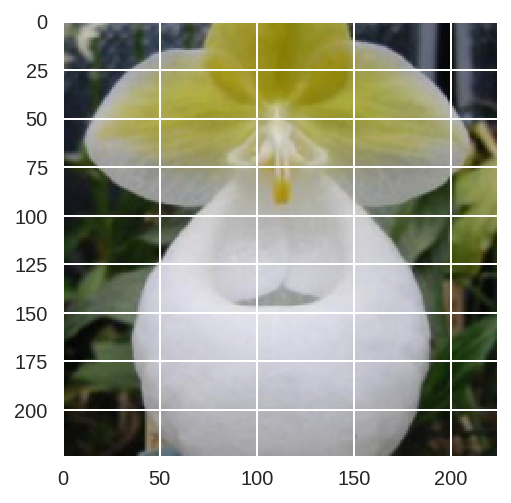

In [0]:
%matplotlib inline

_ = imshow(process_image('flower_data/train/2/image_05090.jpg'))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    inputs = process_image(image_path)
    inputs =  inputs.unsqueeze(0)
    model.eval()
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    with torch.no_grad():   
        inputs= inputs.to(device)
        logps = model.forward(inputs)                    
        # predict top k classes
        ps = torch.exp(logps)
        probs, classes_index = ps.topk(topk, dim=1)
        probs = torch.squeeze(probs, 0).to('cpu').numpy()   
        classes_index = torch.squeeze(classes_index, 0).to('cpu').numpy()
        classes = [idx_to_class[i] for i in classes_index]
    return probs, classes

In [0]:
probs, classes = predict("flower_data/train/1/image_06735.jpg", model)
print(probs)
print(classes)

[0.73921305 0.15669055 0.03946659 0.02860662 0.0098567 ]
['1', '83', '76', '51', '86']


In [0]:
probs, classes = predict("flower_data/train/2/image_05090.jpg", model)
print(probs)
print(classes)

[0.7066286  0.07993435 0.06468381 0.0256085  0.01793538]
['2', '84', '7', '52', '68']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# Display an image along with the top 5 classes

In [0]:
import seaborn as sns
def sanity_check(image_path, model):
    # plot layout
    plt.figure(figsize = (12,4))
    ax = plt.subplot(1,3,1)
    
    # Plot image with true label
    true_label = image_path.split('/')[2]
    title = cat_to_name[true_label]
    img = process_image(image_path)
    imshow(img, ax, title = title);
    
    # Make prediction with deep learning model
    probs, classes = predict(image_path, model)
    classes_names = [cat_to_name[x] for x in classes]
    # Bar chart plotting with predition
    plt.subplot(1,3,3)
    sns.barplot(x=probs, y=classes_names, color=sns.color_palette()[0]);
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


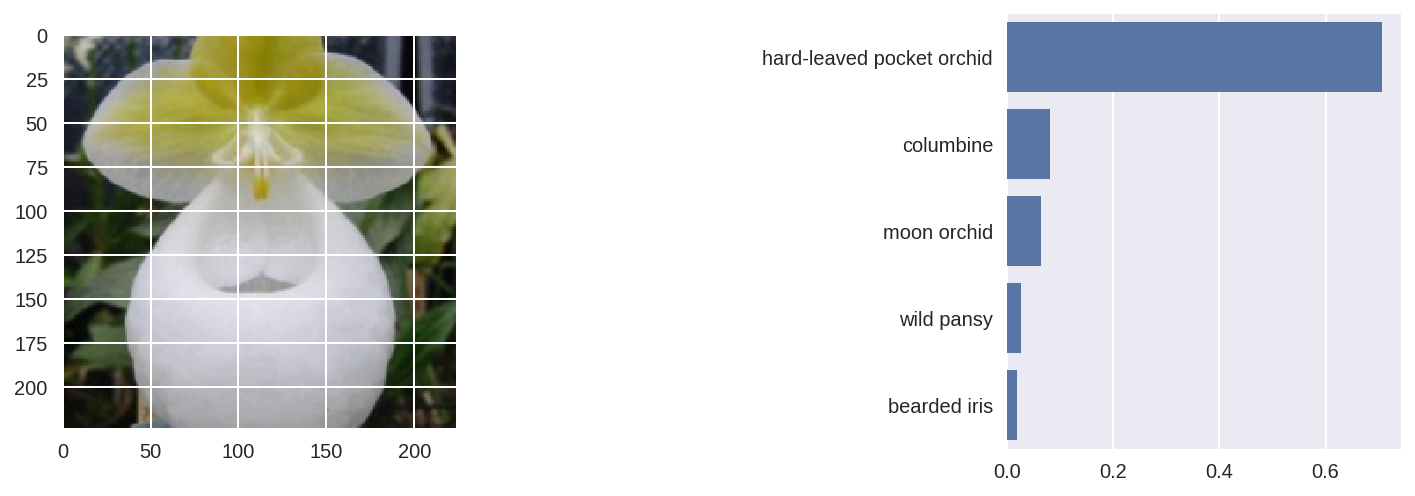

In [0]:
sanity_check('flower_data/train/2/image_05090.jpg',model)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


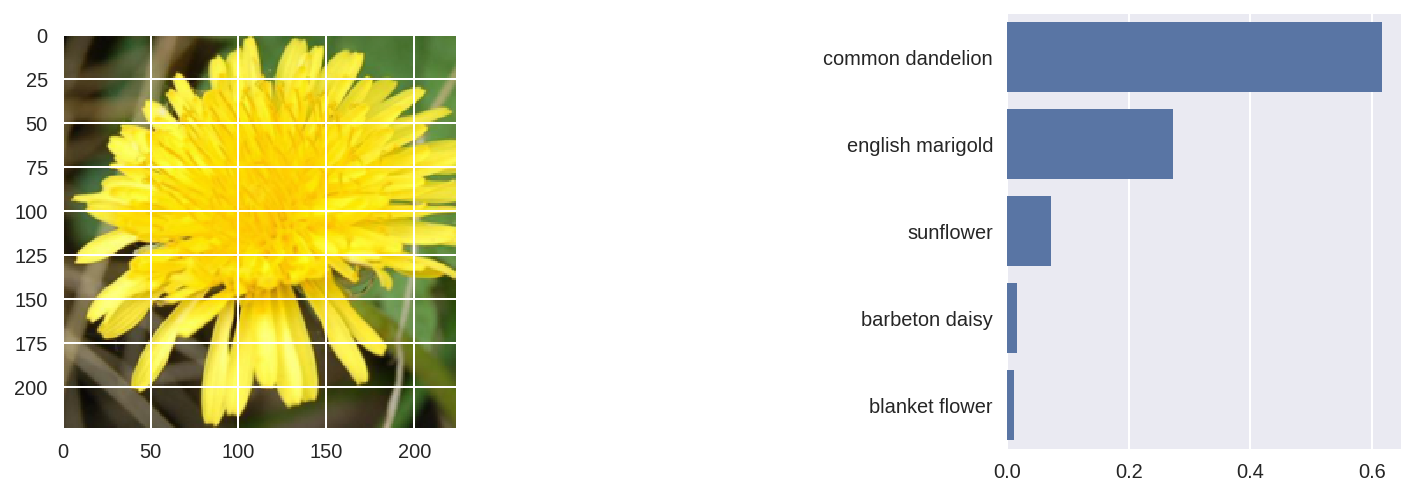

In [0]:
sanity_check('flower_data/valid/50/image_06562.jpg', model)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


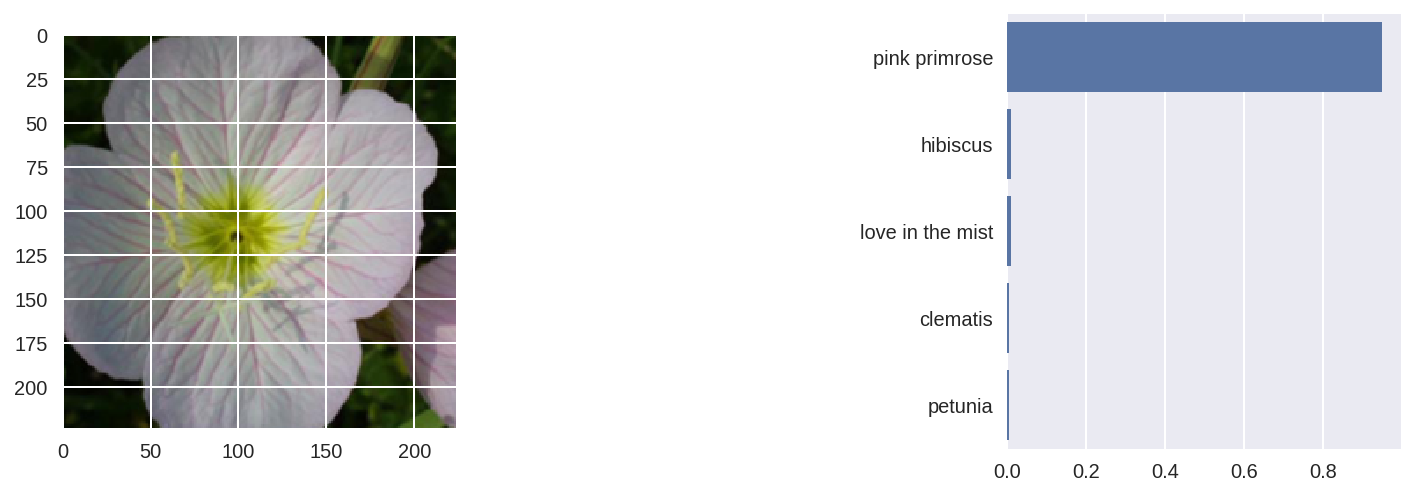

In [0]:
sanity_check('flower_data/train/1/image_06736.jpg', model)